In [ ]:
# imports
import requests
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import random

# Gathering Data

In [ ]:
ensign_providers = pd.read_excel('/content/drive/MyDrive/Our_Provider_numbers.xlsx')

In [ ]:
sql_list_str = ''
for prov_num in set(ensign_providers['our_provnum']):
  sql_list_str = sql_list_str +"provnum='" + str(prov_num) + "' OR "
sql_list_str = sql_list_str[:-3]

In [ ]:
out = requests.api.get(f'https://data.cms.gov/resource/39hn-a9em.csv?$limit=40000&$where={sql_list_str}')

In [ ]:
q4_2020_file = open('2020_q4.csv', 'w')
q4_2020_file.write(out.text)

3730450

In [ ]:
q4_2020_non_nursing = open('2020_q4_non_nursing.csv', 'w')
q4_2020_non_nursing.write(requests.api.get(f'https://data.cms.gov/resource/tfch-mtbk.csv?$limit=40000&$where={sql_list_str}').text)

8088988

In [ ]:
pbj_cy_2020_q4 = pd.read_csv('2020_q4.csv')

In [ ]:
pbj_cy_2020_q4_non_nursing = pd.read_csv('2020_q4_non_nursing.csv')

In [ ]:
pbj_cy_2020_q4_total = pbj_cy_2020_q4_non_nursing.merge(pbj_cy_2020_q4, how='outer')

In [ ]:
pbj_cy_2020_q4_total['workdate'] = pd.to_datetime( pbj_cy_2020_q4_total['workdate'], 
                                            format = '%Y%m%d')

# Analysis

We will be repeatedly using the columns associated with each provider, so we'll create a variable to store them.

In [ ]:
provider_columns = ['provnum', 'provname', 'city', 'state', 'county_name', 'county_fips']

Let's take a look at the daily averages of our data.

In [ ]:
averages_per_day = pbj_cy_2020_q4_total.groupby(by=provider_columns).agg('mean')

Of particular interest might be the question of adminstrative efficiency. How does the amount of time dedicated to the administration of the provider scale with population? Is a particular provider doing better or worse compared to a provider of similar size?

Below is a look at the ratio of administrative hours per day to population.

In [ ]:
((averages_per_day['hrs_admin'] + averages_per_day['hrs_rnadmin']) /averages_per_day['mdscensus']).sort_values(ascending=False)

provnum  provname                                            city          state  county_name  county_fips
135020   RIVER'S EDGE REHABILITATION & LIVING CENTER         EMMETT        ID     Gem          45             0.532505
525348   GREENTREE HEALTH AND REHAB CTR                      CLINTONVILLE  WI     Waupaca      135            0.473626
175558   THE HEALTHCARE RESORT OF LEAWOOD - IRON HORSE HLTH  LEAWOOD       KS     Johnson      91             0.456827
285055   FALLS CITY NURSING AND REHABILITATION CENTER        FALLS CITY    NE     Richardson   147            0.439291
165156   FORT DODGE HEALTH AND REHABILITATION                FORT DODGE    IA     Webster      187            0.430594
                                                                                                                ...   
285240   OMAHA NURSING AND REHABILITATION CENTER             OMAHA         NE     Douglas      55             0.042059
555258   VALLEY OF THE MOON POST ACUTE                      

We can also look at this through a scatterplot of administrative hours vs. population. The result is a fairly linear one. If providers find themselves above this line they may want to consider why the are spending so much time on administration. Those signficantly below the line may want to make sure their bookkeeping is effective.

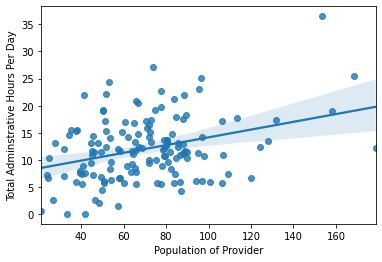

In [ ]:
sb.regplot(x = averages_per_day['mdscensus'], y = averages_per_day['hrs_admin'] + averages_per_day['hrs_rnadmin'])
plt.ylabel('Total Adminstrative Hours Per Day')
plt.xlabel('Population of Provider');

Interestingly, there seems to be a widespread ceiling on the amount of hours non-nurses spend adminstering, specifically at 6 a day. I assume that this is likely due to hiring a single dedicated non-nurse administrator.

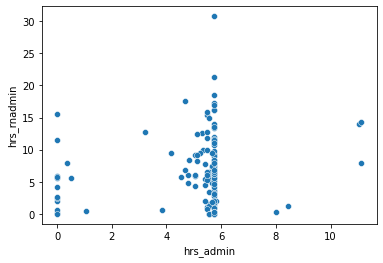

In [ ]:
sb.scatterplot(x = averages_per_day['hrs_admin'], y = averages_per_day['hrs_rnadmin'])

The question then becomes: is it more efficient to hire a dedicated administrator? Here we have the same scatterplot as before, but now the brighter the dot the is, the more nurse administrators there are per non-nurse administrators at the provider. The color gradient is quite perceptible: the more hours put into administration, the more of those hours are done by nurses.

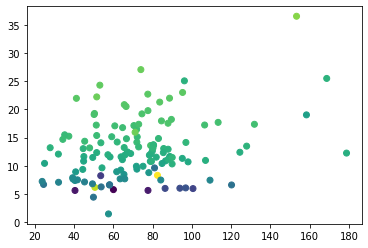

In [ ]:
plt.scatter(x = averages_per_day['mdscensus'], y = averages_per_day['hrs_admin'] 
            + averages_per_day['hrs_rnadmin'], 
            c = averages_per_day['hrs_rnadmin']/averages_per_day['hrs_admin'], 
            cmap = 'viridis',norm=mpl.colors.LogNorm())

The trend becomes clearer if we plot how far above or below the providers are from the typical provider of their size. The lower they are on the plot, the better they are doing. From this, we can see that independent of the population of the provider, more registered nurse administration means more administration overall. The providers that are performing best tend to have a greater ratio of non-nurse administrators. This is even true for the providers with small populations. Therefore it is advisable to work towards minimizing the administrative roles of nurses as much as possible.



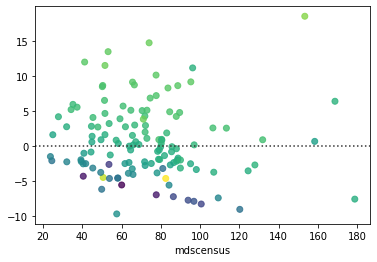

In [ ]:
sb.residplot(x = averages_per_day['mdscensus'], y = averages_per_day['hrs_admin'] 
             + averages_per_day['hrs_rnadmin'], 
             scatter_kws={
            'color': None, 
            'c' : averages_per_day['hrs_rnadmin']/averages_per_day['hrs_admin'], 
            'cmap' : 'viridis',
            'norm' : mpl.colors.LogNorm()})

Does this trend hold for competitors as well?

# More Gathering of Data

In [ ]:
random_competitors = random.sample(range(15009, 686124), 400)

In [ ]:
random_selection = open('random_selection.csv', 'w')
random_selection.write(requests.api.get(f'https://data.cms.gov/resource/39hn-a9em.csv?$limit=40000&$select=provnum&$group=provnum').text)
random_selection.close()
random_selection = pd.read_csv('random_selection.csv')

In [ ]:
sql_com_list_str = ''
for prov_num in set(random_selection.sample(200)['provnum']):
  sql_com_list_str = sql_com_list_str +"provnum='" + str(prov_num) + "' OR "
sql_com_list_str = sql_com_list_str[:-3]

In [ ]:
com_q4_2020 = open('com_2020_q4.csv', 'w')
com_q4_2020.write(requests.api.get(f'https://data.cms.gov/resource/39hn-a9em.csv?$limit=40000&$where={sql_com_list_str}').text)
com_q4_2020.close()

com_q4_2020_non_nursing = open('com_2020_q4_non_nursing.csv', 'w')
com_q4_2020_non_nursing.write(requests.api.get(f'https://data.cms.gov/resource/tfch-mtbk.csv?$limit=40000&$where={sql_com_list_str}').text);
com_q4_2020_non_nursing.close()

In [ ]:
com_pbj_cy_2020_q4 = pd.read_csv('com_2020_q4.csv')
com_pbj_cy_2020_q4_non_nursing = pd.read_csv('com_2020_q4_non_nursing.csv')
com_pbj_cy_2020_q4_total = com_pbj_cy_2020_q4_non_nursing.merge(com_pbj_cy_2020_q4, how='outer')
com_pbj_cy_2020_q4_total['workdate'] = pd.to_datetime( com_pbj_cy_2020_q4_total['workdate'], 
                                            format = '%Y%m%d')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
com_pivoted_data = com_pbj_cy_2020_q4_total.drop('cy_qtr', axis=1).pivot(index='workdate', columns=provider_columns)
com_averages_per_day = com_pbj_cy_2020_q4_total.groupby(by=provider_columns).agg('mean')

# Competitor Analysis

Here is the same plot as before, but now for a random selection of 200 competitors. As we can see, the trend is still fairly linear.

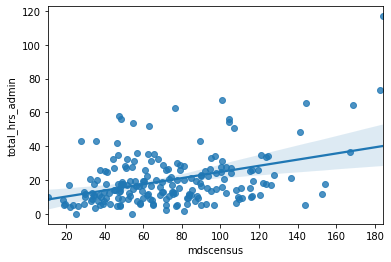

In [ ]:
sb.regplot(x = com_averages_per_day['mdscensus'], y = com_averages_per_day['hrs_admin'] + com_averages_per_day['hrs_rnadmin'])
plt.ylabel('total_hrs_admin');

Once again we see a ceiling at 6 hours a day of non-nurse admin.

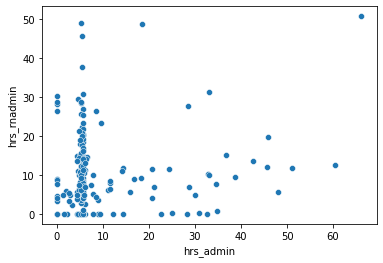

In [ ]:
sb.scatterplot(x = com_averages_per_day['hrs_admin'], y = com_averages_per_day['hrs_rnadmin'])

However when it comes to the impact of the ratio of administrative work, the pattern isn't quite as distinct. In particular, while the best performers tend have a lower ratio than middle of the road performers, the worst performers are a mixture of both extremes.

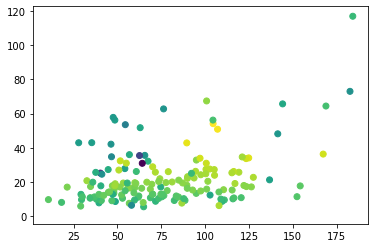

In [ ]:
plt.scatter(x = com_averages_per_day['mdscensus'], y = com_averages_per_day['hrs_admin'] 
            + com_averages_per_day['hrs_rnadmin'], 
            c = com_averages_per_day['hrs_rnadmin']/com_averages_per_day['hrs_admin'], 
            cmap = 'viridis',norm=mpl.colors.LogNorm())

This can be seen more readily in the residual plot.

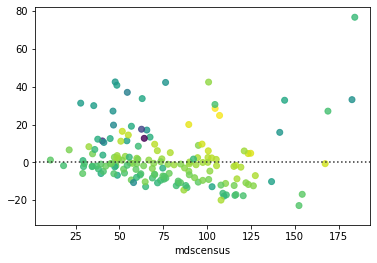

In [ ]:
sb.residplot(x = com_averages_per_day['mdscensus'], y = com_averages_per_day['hrs_admin'] 
             + com_averages_per_day['hrs_rnadmin'], 
             scatter_kws={
            'color': None, 
            'c' : com_averages_per_day['hrs_rnadmin']/com_averages_per_day['hrs_admin'], 
            'cmap' : 'viridis',
            'norm' : mpl.colors.LogNorm()})

This is fairly encouraging for Ensign providers. Their data looks like the competitor data with the more extreme outliers removed, suggesting that many sources of inefficiency that impact other providers are not an issue for Ensign providers. 

Lastly, we can compare the two sets, and sure enough, the trendline for Ensign providers (in blue) is below that of the typical provider (in green). For the small number of Ensign providers that are underperforming compared to the nation, the evidence suggests the best course of action is to transfer more of the administrative load from nurses to other employees.

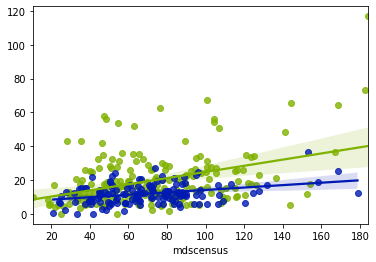

In [ ]:
sb.regplot(x = com_averages_per_day['mdscensus'], y = com_averages_per_day['hrs_admin'] + com_averages_per_day['hrs_rnadmin'], color=[0.5, 0.7,0, 0.9])
sb.regplot(x = averages_per_day['mdscensus'], y = averages_per_day['hrs_admin'] + averages_per_day['hrs_rnadmin'], color=[0, 0.1 ,0.7, 0.4])